# **Data Augmentation**

So far, we've selected a model architecture that vastly improves the model's performance, as it is designed to recognize important features in the images. **The validation accuracy is still lagging behind the training accuracy, which is a sign of overfitting: the model is getting confused by things it has not seen before when it tests against the validation dataset.**

In order to teach our model to be more robust when looking at new data, we're going to **programmatically increase the size and variance in our dataset.** This is known as [*data augmentation*](https://link.springer.com/article/10.1186/s40537-019-0197-0), a useful technique for many deep learning applications.

The increase in size gives the model more images to learn from while training. The increase in variance helps the model ignore unimportant features and select only the features that are truly important in classification, allowing it to generalize better.

## Objectives

* Augment the ASL dataset
* Use the augmented data to train an improved model
* Save the well-trained model to disk for use in deployment

## Preparing the Data

As we're in a new notebook, we will load and process our data again. To do this, execute the following cell:

In [1]:
import tensorflow.keras as keras
import pandas as pd

# load in our data from CSV files
train_df = pd.read_csv("/content/sign_mnist_train.csv")
valid_df = pd.read_csv("/content/sign_mnist_valid.csv")

# separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

## Model Creation

We will also need to create our model again. 

<center><img src="https://i.postimg.cc/xdhhXptj/cnn.png" width="200"></center>

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

## Data Augmentation

Before compiling the model, it's time to set up our data augmentation.

Keras comes with an image augmentation class called `ImageDataGenerator`. We recommend checking out the [documentation here](https://keras.io/api/preprocessing/image/#imagedatagenerator-class). It accepts a series of options for augmenting your data.

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # eandomly zoom images
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # don't randomly flip images vertically
)  

Our dataset is pictures of hands signing the alphabet. **If we want to use this model to classify hand images later, it's unlikely that those hands are going to be upside-down, but, they might be left-handed.** This kind of **domain-specific reasoning** can help make good decisions for your own deep learning applications.

## Batch Size
Another benefit of the `ImageDataGenerator` is that it [batches](https://machinelearningmastery.com/how-to-control-the-speed-and-stability-of-training-neural-networks-with-gradient-descent-batch-size/) our data so that our model can train on a random sample.

If the model is [truly random](http://sites.utexas.edu/sos/random/), meaning that the data is properly shuffled so it's fair like a deck of cards, then our sample can do a good job of representing all of our data even though it is a tiny fraction of the population. For each step of the training, the model will be dealt a new batch.

**In practice, a batch size of 32 and 64 does well.** The cell below will run to **see what kind of batches we'll be training our model with.** Is our randomizer fairly randomizing? Are all of the images recognizable ASL letters?

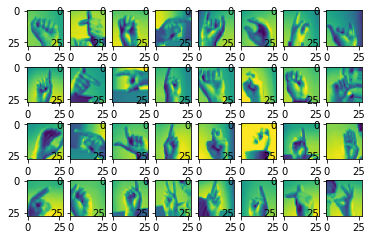

In [4]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

## Fitting the Data to the Generator

Next, **the generator must be fit on the training dataset.**

In [5]:
datagen.fit(x_train)

## Compiling the Model

With the data generator instance created and fit to the training data, **the model can now be compiled** in the same way as our earlier examples:

In [6]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## Training with Augmentation

When using an image data generator with Keras, a model trains a bit differently: instead of just passing the `x_train` and `y_train` datasets into the model, we pass the generator in, calling the generator's [flow](https://keras.io/api/preprocessing/image/) method. **This causes the images to get augmented live and in memory right before they are passed into the model for training.**

Generators can supply an indefinite amount of data, and when we use them to train our data, we need to explicitly set how long we want each epoch to run, or else the epoch will go on indefinitely, with the generator creating an indefinite number of augmented images to provide the model.

We explicitly set how long we want each epoch to run using the `steps_per_epoch` named argument. Because **`steps * batch_size = number_of_images_trained in an epoch`** a common practice, that we will use here, is to set the number of steps equal to the non-augmented dataset size divided by the batch_size (which has a default value of 32).

The training will take longer than before, which makes sense given we are now training on more data than previously:

In [7]:
model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # run same number of steps we would if we were not using a generator
          validation_data=(x_valid, y_valid))

Epoch 1/20
857/857 [==============================] - 119s 135ms/step - loss: 1.1271 - accuracy: 0.6437 - val_loss: 0.4798 - val_accuracy: 0.8101
Epoch 2/20
857/857 [==============================] - 114s 133ms/step - loss: 0.3353 - accuracy: 0.8858 - val_loss: 0.2076 - val_accuracy: 0.9195
Epoch 3/20
857/857 [==============================] - 116s 135ms/step - loss: 0.2020 - accuracy: 0.9328 - val_loss: 0.1980 - val_accuracy: 0.9310
Epoch 4/20
857/857 [==============================] - 115s 134ms/step - loss: 0.1568 - accuracy: 0.9499 - val_loss: 0.1111 - val_accuracy: 0.9594
Epoch 5/20
857/857 [==============================] - 114s 132ms/step - loss: 0.1265 - accuracy: 0.9588 - val_loss: 0.0339 - val_accuracy: 0.9838
Epoch 6/20
857/857 [==============================] - 117s 136ms/step - loss: 0.1128 - accuracy: 0.9639 - val_loss: 0.0682 - val_accuracy: 0.9745
Epoch 7/20
857/857 [==============================] - 115s 134ms/step - loss: 0.0971 - accuracy: 0.9692 - val_loss: 0.0541 -

## Discussion of Results

You will notice that **the validation accuracy is higher, and more consistent.** This means that our **model is no longer overfitting in the way it was; it generalizes better, making better predictions on new data.**

## Saving the Model

Now that we have a well-trained model, we will want to deploy it to perform inference on new images.

It is common, once we have a trained model that we are happy with to save it to disk.

Saving the model in Keras is quite easy using the save method. There are different formats that we can save in, but we'll use the default for now. If you'd like, feel free to check out [the documentation](https://www.tensorflow.org/guide/keras/save_and_serialize). In the next notebook, we'll load the model and use it to read new sign language pictures:

In [8]:
model.save('asl_model')

INFO:tensorflow:Assets written to: asl_model/assets


## Summary

In this section we used Keras to augment our dataset, **the result being a trained model with less overfitting and excellent validation image results.**

<hr>
<hr>
<hr>

# **Model Deployment**
Now that we have a well trained model, it's time to use it. In this exercise, we'll expose new images to our model and detect the correct letters of the sign language alphabet. 

## Objectives

* Load an already-trained model from disk
* Reformat images for a model trained on images of a different format
* Perform inference with new images, never seen by the trained model and evaluate its performance

## Loading the Model
Let's load the saved model that we trained. Our save from the previous exercise created a folder called **"asl_model"**. We can load the model by selecting the same folder.

In [9]:
from tensorflow import keras

model = keras.models.load_model('/content/asl_model')



```
##### PREPARING THE DATA

import tensorflow.keras as keras
import pandas as pd

# load in our data from CSV files
train_df = pd.read_csv("/content/sign_mnist_train.csv")
valid_df = pd.read_csv("/content/sign_mnist_valid.csv")

# separate out our target values
y_train = train_df['label']
y_valid = valid_df['label']
del train_df['label']
del valid_df['label']

# separate our our image vectors
x_train = train_df.values
x_valid = valid_df.values

# turn our scalar targets into binary categories
num_classes = 24
y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

# normalize our image data
x_train = x_train / 255
x_valid = x_valid / 255

# reshape the image data for the convolutional network
x_train = x_train.reshape(-1,28,28,1)
x_valid = x_valid.reshape(-1,28,28,1)

##### MODEL CREATION

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

##### DATA AUGMENTATION

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # randomly zoom images
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # don't randomly flip images vertically
)  

##### BATCH SIZE

import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

##### FITTING THE DATA TO THE GENERATOR

datagen.fit(x_train)

##### COMPILING THE MODEL

model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

##### TRAINING WITH AUGMENTATION

model.fit(img_iter,
          epochs=20,
          steps_per_epoch=len(x_train)/batch_size, # run same number of steps we would if we were not using a generator
          validation_data=(x_valid, y_valid))

##### SAVING THE MODEL

model.save('asl_model')
```



To make sure everything looks intact, we can see the summary of the model again.

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 75)        750       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 75)       300       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 75)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 50)        33800     
                                                                 
 dropout (Dropout)           (None, 14, 14, 50)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 50)       2

## Preparing an Image for the Model

It's now time to **use the model to make predictions on new images that it's never seen before.** This is also called **inference.** There's a set of images in the data/asl_images folder.

You'll notice that **the images we have are much higher resolution than the images in our dataset.** **They are also in color.** Remember that our images in the dataset were 28x28 pixels and grayscale. **It's important to keep in mind that whenever you make predictions with a model, the input must match the shape of the data that the model was trained on**. For this model, the training dataset was of the shape: (27455, 28, 28, 1). This corresponded to 27455 images of 28 by 28 pixels each with one color channel (grayscale). 

### Showing the Images

When we use our model to make predictions on new images, it will be useful to show the image as well. We can use the matplotlib library to do this.

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image, cmap='gray')

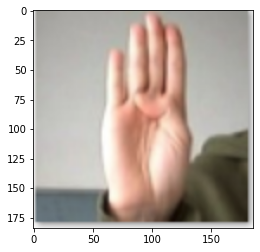

In [12]:
show_image('/content/asl_images/b.png')

### Scaling the Images

The images in our dataset were 28x28 pixels and grayscale. **We need to make sure to pass the same size and grayscale images into our method for prediction.** There are a few ways to edit images with Python, but Keras has a built-in utility that works well. 

In [13]:
from tensorflow.keras.preprocessing import image as image_utils

def load_and_scale_image(image_path):
    image = image_utils.load_img(image_path, color_mode="grayscale", target_size=(28,28))
    return image

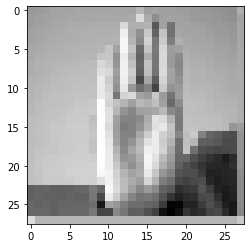

In [14]:
image = load_and_scale_image('/content/asl_images/b.png')
plt.imshow(image, cmap='gray')

### Preparing the Image for Prediction

Now that we have a 28x28 pixel grayscale image, we're close to being ready to pass it into our model for prediction. First, we need to **reshape our image to match the shape of the dataset the model was trained on.** Before we can reshape, we need to **convert our image into a more rudimentary format.** We'll do this with a keras utility called image_to_array.

In [15]:
image = image_utils.img_to_array(image)

Now we can reshape our image to get it ready for prediction.

In [16]:
# this reshape corresponds to 1 image of 28x28 pixels with one color channel
image = image.reshape(1,28,28,1) 

Finally, we should **remember to normalize our data (making all values between 0-1)**, as we did with our training dataset:

In [17]:
image = image / 255

## Making Predictions

Okay, now we're ready to predict! This is done by **passing our pre-processed image into the model's predict method.**

In [18]:
prediction = model.predict(image)
print(prediction)

[[1.0364588e-20 1.0000000e+00 2.0822485e-22 1.4882117e-23 3.3662377e-13
  1.6095747e-10 2.8489766e-28 1.9278215e-31 4.0422748e-17 3.1084106e-26
  4.3691987e-21 1.4560760e-20 4.6233979e-26 6.8675553e-36 2.2189767e-31
  1.4213158e-27 1.6965077e-23 5.6972499e-28 5.5795167e-35 2.5637917e-13
  1.0137947e-34 2.1490318e-17 6.1032219e-19 8.4920048e-24]]


### Understanding the Prediction

**The predictions are in the format of a 24 length array.** Though it looks a bit different, **this is the same format as our "binarized" categorical arrays from y_train and y_test**. Each element of the array is a probability between 0 and 1, representing the confidence for each category. Let's make it a little more readable. We can start by **finding which element of the array represents the highest probability.** This can be done easily with the numpy library and the [argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) function.

In [19]:
import numpy as np
np.argmax(prediction)

1

**Each element of the prediction array represents a possible letter in the sign language alphabet.** Remember that j and z are not options because they involve moving the hand, and we're only dealing with still photos. Let's create a mapping between the index of the predictions array, and the corresponding letter. 

In [20]:
# alphabet does not contain j or z because they require movement
alphabet = "abcdefghiklmnopqrstuvwxy"
dictionary = {}
for i in range(24):
    dictionary[i] = alphabet[i]
dictionary

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'k',
 10: 'l',
 11: 'm',
 12: 'n',
 13: 'o',
 14: 'p',
 15: 'q',
 16: 'r',
 17: 's',
 18: 't',
 19: 'u',
 20: 'v',
 21: 'w',
 22: 'x',
 23: 'y'}

We can now pass in our prediction index to find the corresponding letter.

In [21]:
dictionary[np.argmax(prediction)]

'b'

## Putting it all Together

Let's **put everything in a function so that we can make predictions just from the image file.** Implement it in the function below using the functions and steps above. 

In [22]:
def predict_letter(file_path):
    # show image
    show_image(file_path)
    # load and scale image
    image = load_and_scale_image(file_path)
    # convert to array
    image = image_utils.img_to_array(image)
    # reshape image
    image = image.reshape(1,28,28,1) 
    # normalize image
    image = image/255
    # make prediction
    prediction = model.predict(image)
    # convert prediction to letter
    predicted_letter = dictionary[np.argmax(prediction)]
    # return prediction
    return predicted_letter  

'b'

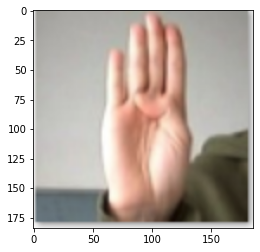

In [23]:
predict_letter("/content/asl_images/b.png")

Let's also use the function with the 'a' letter in the asl_images datset:

'a'

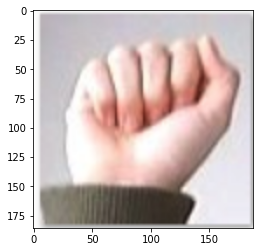

In [24]:
predict_letter("/content/asl_images/a.png")

## Summary

We've gone through the full process of training a highly accurate model from scratch, and then using the model to make new and valuable predictions. We can imagine how this model could be used in an application to teach someone sign language, or even help someone who cannot speak interact with a computer. 

<hr>

**Source**: [NVIDIA Deep Learning Institute](https://www.nvidia.com/en-us/training/)

<hr>